In [1]:
from importlib import reload
import utils as d; reload(d)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load data

In [2]:
df = d.load_dataset()

In [3]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


<div style="text-align:center"><img width="500px" src="./images/tumor-nuclei.png/"></div>
<br>
<br>
<div style="text-align:center">Figure 1: Tumor Nuclei.</div>

## Create X and Y

In [4]:
PREDICTED_COLUMNS = ['diagnosis']
FEATURES = ['mean']

In [5]:
x, y = d.create_xy(df, FEATURES, PREDICTED_COLUMNS)

In [6]:
x = d.preprocess_data(x)

## Split Train, Val & Test

In [7]:
(x_train, y_train), (x_val, y_val), (x_test, y_test) = d.split_train_val_test(x, y, train_perc=0.6)

In [8]:
print('# Examples for training:', len(x_train))
print('# Examples for validation:', len(x_val))
print('# Examples for test:',  len(x_test))

# Examples for training: 214
# Examples for validation: 177
# Examples for test: 178


## Evaluate Features

### Covariance Matrix

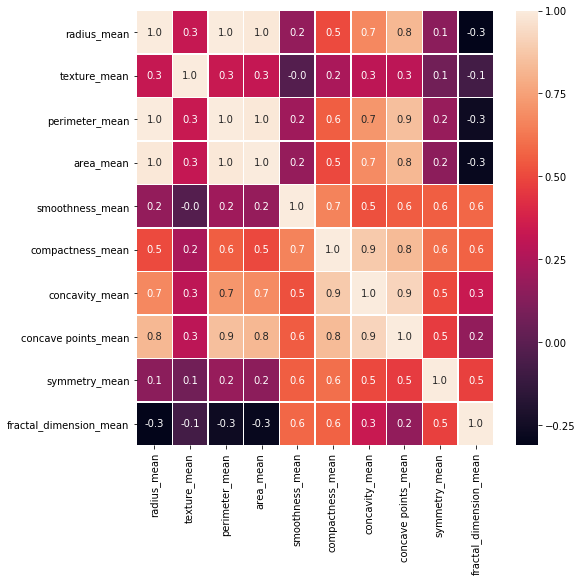

In [9]:
f, ax = plt.subplots(figsize=(x.shape[1] -2, x.shape[1] -2))
sns.heatmap(x.corr(), annot=True, linewidths=.5, fmt= '.1f', ax=ax)

### PCA

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
basis = pca.fit(x_train)

In [11]:
x_train = basis.transform(x_train)
x_val = basis.transform(x_val)
x_test = basis.transform(x_test)

In [12]:
x_train, y_train = x_train[:, 1:], np.vstack([x_train[:, 0], y_train[:, 0]]).T
x_val, y_val = x_val[:, 1:], np.vstack([x_val[:, 0], y_val[:, 0]]).T
x_test, y_test = x_test[:, 1:], np.vstack([x_test[:, 0], y_test[:, 0]]).T

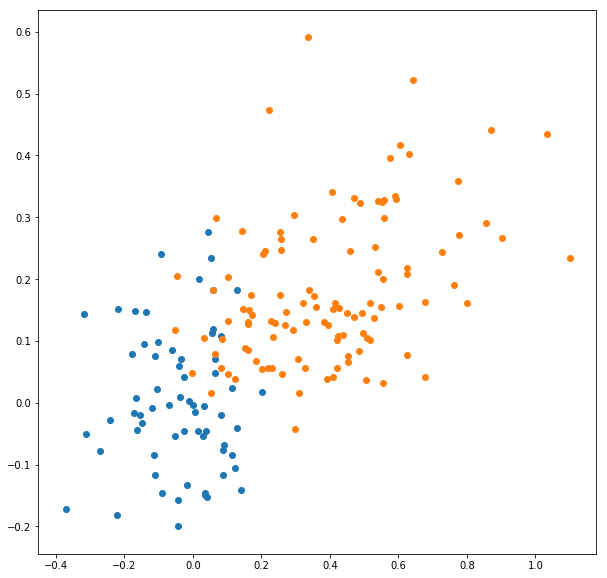

In [13]:
plt.figure(figsize=(10, 10))
plt.scatter(x_val[y_val[:, 1] == 'B', 0], x_val[y_val[:, 1] == 'B', 1])
plt.scatter(x_val[y_val[:, 1] == 'M', 0], x_val[y_val[:, 1] == 'M', 1])

## Ensemble of models

### Create an ensemble of models

In [ ]:
import keras
from keras.layers import *
from keras.models import Model, Sequential
from keras.regularizers import l1_l2
from collections import defaultdict

c:\users\bearch\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
N_FEATURES = x_train.shape[1]

In [ ]:
def create_base_model(input_size, n_hidden):
    i = Input((input_size, ))
    h = Dense(n_hidden, kernel_initializer='normal', use_bias=True)(i)
    h = LeakyReLU()(h)
    o = Dense(1)(h)
    return Model(i, o)

In [ ]:
models = []
N_MODELS = 5
n_hidden_neurons = 64
for _ in range(N_MODELS):
    models.append(create_base_model(N_FEATURES, n_hidden_neurons))

In [ ]:
models[0].summary()

### Train ensemble

In [ ]:
def train(model, train_data, val_data, lr, batch_size, epochs=50, history=None):
    current_epoch = 0 if history is None else len(history.history['loss'])
    model.compile(
        loss='mean_squared_error',
        optimizer=keras.optimizers.Adam(lr=lr),
        metrics=['mse']
    )
    
    new_history = model.fit(
        train_data[0], train_data[1], epochs=current_epoch+epochs,
        batch_size=batch_size,
        validation_data=val_data,
        initial_epoch=current_epoch,
        verbose=1
    )
    
    if history is not None:
        for key in new_history.history:
            history.history[key].extend(new_history.history[key])
    else:
        history = new_history
    
    return history

In [ ]:
histories = defaultdict(lambda: None)

In [ ]:
for lr in [0.1, 0.05, 0.01, 0.005]:
    for i in range(N_MODELS):
        histories[i] = train(models[i], [x_train, y_train[:, 0]], (x_val, y_val[:, 0]), 
                             lr, batch_size=300, epochs=20, history=histories[i])

In [ ]:
plt.title('Loss')
plt.plot(histories[0].history['loss'], label='Train Loss')
plt.plot(histories[0].history['val_loss'], label='Val Loss')
plt.show()

## Predict target feature using ensemble

In [ ]:
y_train_preds = []
y_val_preds = []
y_test_preds = []

for model in models:
    y_train_preds.append(model.predict(x_train))
    y_val_preds.append(model.predict(x_val))
    y_test_preds.append(model.predict(x_test))

In [ ]:
plt.figure(figsize=(10, 8))
plt.title('Predictions on Training Set vs Real values')
plt.scatter(np.mean(y_train_preds, axis=0), y_train[:, 0])
plt.show()

In [ ]:
plt.figure(figsize=(10, 8))
plt.title('Predictions on Validation Set vs Real values')
plt.scatter(np.mean(y_val_preds, axis=0)[y_val[:, 1] == 'B'], y_val[y_val[:, 1] == 'B', 0], label='benign')
plt.scatter(np.mean(y_val_preds, axis=0)[y_val[:, 1] == 'M'], y_val[y_val[:, 1] == 'M', 0], label='malignant')
plt.legend()
plt.show()

## Use ensemble variance to predict diagnosis 

In [ ]:
y_train_preds_var = np.var(y_train_preds, axis=0)
y_val_preds_var = np.var(y_val_preds, axis=0)
y_test_preds_var = np.var(y_test_preds, axis=0)

In [ ]:
f, ax = plt.subplots(1, 3, figsize=(20, 8), sharey=True, sharex=True)
ax[0].set_title('Variance histogram in Train Benign')
ax[0].hist(y_train_preds_var, bins=10)
ax[1].set_title('Variance histogram in Validation Benign')
ax[1].hist(y_val_preds_var[y_val[:, 1] == 'B'], bins=10)
ax[2].set_title('Variance histogram in Validation Malignant')
ax[2].hist(y_val_preds_var[y_val[:, 1] == 'M'], bins=10)
plt.axis([0, 0.01, 0, 100])
plt.show()

In [ ]:
plt.figure(figsize=(12, 8))
plt.hist(y_train_preds_var, color='b',  bins=50, label='train')
plt.hist(y_val_preds_var[y_val[:, 1] == 'M'], fc=(0, 1, 0, 0.5), bins=200, label='val_malignant')
plt.hist(y_val_preds_var[y_val[:, 1] == 'B'], fc=(1, 0, 0, 0.5), bins=50, label='val_benign')
plt.legend()
plt.show()

### Select variance threshold

In [ ]:
def predict(y_preds_var, y, threshold):
    predictions = []
    
    for pred in y_preds_var:
            predictions.append(pred > threshold) 
    
    return predictions
    
def weighted_accuracy(y_preds_var, y, threshold):
    accs = []
    weights = []
    
    _, counts = np.unique(y[:, 1], return_counts=True)
    try:
        weight_b = counts[1]
        weight_m = counts[0]
    except:
        weight_b = 1
        weight_m = 1
    
    for i, pred in enumerate(y_preds_var):
        if y[i, 1] == 'B':
            accs.append(pred < threshold)
            weights.append(weight_b) 
        elif y[i, 1] == 'M':
            accs.append(pred > threshold)
            weights.append(weight_m)

    return np.average(accs, axis=0, weights=weights)[0] * 100

In [ ]:
thresholds = np.linspace(0, 10, 500) *  y_train_preds_var.mean()
accs = []

for thr in thresholds:
    accs.append(weighted_accuracy(y_val_preds_var, y_val, thr))

threshold = thresholds[np.argmax(accs)]

In [ ]:
plt.title('Validation Accuracy vs Threshold change')
plt.plot(thresholds, accs)
plt.show()

## Evaluation Metrics

In [ ]:
print('Training Accuracy: %.1f%%' % weighted_accuracy(y_train_preds_var, y_train, threshold))

In [ ]:
print('Validation Accuracy: %.1f%%' % weighted_accuracy(y_val_preds_var, y_val, threshold))

In [ ]:
print('Test Accuracy: %.1f%%' % weighted_accuracy(y_test_preds_var, y_test, threshold))

### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

#### Validation

In [ ]:
y_val_pred = predict(y_val_preds_var, y_val, threshold)
y_val_bool = [True if o == 'M' else False for o in y_val[:, 1]]

In [ ]:
d.plot_confusion_matrix(confusion_matrix(y_val_bool, y_val_pred), [False, True])

#### Test

In [ ]:
y_test_pred = predict(y_test_preds_var, y_test, threshold)
y_test_bool = [True if o == 'M' else False for o in y_test[:, 1]]

In [ ]:
d.plot_confusion_matrix(confusion_matrix(y_test_bool, y_test_pred), [False, True])

Done!